<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/Experiment/Heteroscedastic_Temporal_Variational_Autoencoder_for_Irregularly_Sampled_Time_Series_(HetVAE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/reml-lab/hetvae.git

Cloning into 'hetvae'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 34 (delta 10), reused 9 (delta 9), pack-reused 20
Unpacking objects: 100% (34/34), done.


In [2]:
%cd hetvae/

/content/hetvae


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
import sys
sys.path.insert(0,'/content/hetvae/src')

In [5]:
import models

In [6]:
import numpy as np
import torch
import torch.optim as optim
import models
import utils
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [8]:
args = Namespace(batch_size=128, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=128, enc_num_heads=1, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.0001, mixing='concat', mse_weight=0.0, n=2000, net='hetvae', 
                 niters=2000, norm=True, normalize_input='znorm', num_ref_points=16, rec_hidden=16, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512)

In [9]:
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
data_obj = utils.get_synthetic_data(args)
train_loader = data_obj["train_dataloader"]
test_loader = data_obj["test_dataloader"]
val_loader = data_obj["val_dataloader"]
gt = data_obj['ground_truth']
dim = data_obj["input_dim"]
union_tp = utils.union_time(train_loader)

(2000, 51, 3)
(1600, 51, 3) (320, 51, 3) (400, 51, 3)


In [19]:
def from_obj_into_shape(ts):
  print(f"shape is {next(iter(ts)).shape}")
  return next(iter(ts))

In [21]:
from_obj_into_shape(val_loader)

shape is torch.Size([128, 51, 3])


tensor([[[-0.0291,  1.0000,  0.0000],
         [ 0.3182,  1.0000,  0.0200],
         [ 0.3511,  1.0000,  0.0400],
         ...,
         [-0.4961,  1.0000,  0.9600],
         [-0.4184,  1.0000,  0.9800],
         [-0.2513,  1.0000,  1.0000]],

        [[-0.2797,  1.0000,  0.0000],
         [-0.0340,  1.0000,  0.0200],
         [ 0.1695,  1.0000,  0.0400],
         ...,
         [ 0.6583,  1.0000,  0.9600],
         [ 1.1537,  1.0000,  0.9800],
         [ 0.9960,  1.0000,  1.0000]],

        [[-1.4791,  1.0000,  0.0000],
         [-1.3756,  1.0000,  0.0200],
         [-1.5611,  1.0000,  0.0400],
         ...,
         [ 1.0470,  1.0000,  0.9600],
         [ 1.2012,  1.0000,  0.9800],
         [ 1.6177,  1.0000,  1.0000]],

        ...,

        [[-0.7100,  1.0000,  0.0000],
         [-0.6102,  1.0000,  0.0200],
         [-0.7844,  1.0000,  0.0400],
         ...,
         [ 0.6661,  1.0000,  0.9600],
         [ 0.6727,  1.0000,  0.9800],
         [ 0.7977,  1.0000,  1.0000]],

        [[

In [22]:
from_obj_into_shape(train_loader)

shape is torch.Size([128, 51, 3])


tensor([[[ 0.4388,  1.0000,  0.0000],
         [ 0.6020,  1.0000,  0.0200],
         [ 0.5384,  1.0000,  0.0400],
         ...,
         [ 0.5220,  1.0000,  0.9600],
         [ 0.1652,  1.0000,  0.9800],
         [-0.1256,  1.0000,  1.0000]],

        [[ 1.0799,  1.0000,  0.0000],
         [ 0.7247,  1.0000,  0.0200],
         [ 0.4759,  1.0000,  0.0400],
         ...,
         [-0.4150,  1.0000,  0.9600],
         [-0.0988,  1.0000,  0.9800],
         [-0.1546,  1.0000,  1.0000]],

        [[ 0.2049,  1.0000,  0.0000],
         [ 0.2299,  1.0000,  0.0200],
         [ 0.2407,  1.0000,  0.0400],
         ...,
         [-0.7065,  1.0000,  0.9600],
         [-0.6579,  1.0000,  0.9800],
         [-0.3852,  1.0000,  1.0000]],

        ...,

        [[-0.2663,  1.0000,  0.0000],
         [-0.2331,  1.0000,  0.0200],
         [-0.3585,  1.0000,  0.0400],
         ...,
         [-0.9797,  1.0000,  0.9600],
         [-1.5698,  1.0000,  0.9800],
         [-1.8973,  1.0000,  1.0000]],

        [[

In [23]:
net = models.load_network(args, dim, union_tp)
params = list(net.parameters())
optimizer = optim.Adam(params, lr=args.lr)

In [24]:
for itr in range(1, args.niters + 1):
      train_loss = 0
      train_n = 0
      avg_loglik, avg_kl, mse, mae = 0, 0, 0, 0
      for train_batch in train_loader:
          batch_len = train_batch.shape[0]
          train_batch = train_batch.to(device)
          subsampled_mask = torch.zeros_like(
              train_batch[:, :, dim:2 * dim]).to(device)
          seqlen = train_batch.size(1)
          for i in range(batch_len):
              length = np.random.randint(low=3, high=10)
              obs_points = np.sort(
                  np.random.choice(np.arange(seqlen), size=length, replace=False)
              )
              subsampled_mask[i, obs_points, :] = 1
          recon_mask = train_batch[:, :, dim:2 * dim] - subsampled_mask
          context_y = torch.cat((
              train_batch[:, :, :dim] * subsampled_mask, subsampled_mask
          ), -1)

          loss_info = net.compute_unsupervised_loss(
              train_batch[:, :, -1],
              context_y,
              train_batch[:, :, -1],
              torch.cat((
                  train_batch[:, :, :dim] * recon_mask, recon_mask
              ), -1),
              num_samples=args.k_iwae,
              beta=1,
          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      if itr % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  itr,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
          for loader, num_samples in [(val_loader, 5), (test_loader, 100)]:
              utils.evaluate_hetvae(
                  net,
                  dim,
                  loader,
                  0.5,
                  shuffle=False,
                  k_iwae=num_samples,
                  #net=args.net,
              )

Iter: 100, train loss: 0.9238, avg nll: 0.9234, avg kl: 0.0003, mse: 0.378859, mae: 0.481848
nll: 0.8503, mse: 0.3224, mae: 0.4483, mean_mse: 0.3219, mean_mae: 0.4479
nll: 0.8543, mse: 0.3236, mae: 0.4501, mean_mse: 0.3230, mean_mae: 0.4496
Iter: 200, train loss: 0.6810, avg nll: 0.6809, avg kl: 0.0002, mse: 0.269883, mae: 0.390836
nll: 0.4928, mse: 0.1416, mae: 0.2914, mean_mse: 0.1414, mean_mae: 0.2911
nll: 0.5584, mse: 0.1505, mae: 0.2994, mean_mse: 0.1502, mean_mae: 0.2990
Iter: 300, train loss: 0.5969, avg nll: 0.5968, avg kl: 0.0001, mse: 0.253814, mae: 0.373033
nll: 0.3080, mse: 0.0963, mae: 0.2378, mean_mse: 0.0961, mean_mae: 0.2375
nll: 0.3660, mse: 0.1003, mae: 0.2416, mean_mse: 0.1000, mean_mae: 0.2413
Iter: 400, train loss: 0.5614, avg nll: 0.5612, avg kl: 0.0001, mse: 0.248831, mae: 0.366838
nll: 0.1866, mse: 0.0782, mae: 0.2129, mean_mse: 0.0781, mean_mae: 0.2126
nll: 0.2194, mse: 0.0791, mae: 0.2134, mean_mse: 0.0789, mean_mae: 0.2131
Iter: 500, train loss: 0.5431, avg n

In [ ]:
def viz(test_loader, k_iwae=1, n_max=20):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    with torch.no_grad():
        for low in [3, 10, 20]:
            for batch in test_loader:
                batch_len = batch.shape[0]
                batch = batch.to(device)
                subsampled_mask = torch.zeros_like(batch[:, :, dim:2 * dim]).to(device)
                seqlen = batch.size(1)
                for i in range(batch_len):
                    length = np.random.randint(low=low, high=low + 1)
                    obs_points = np.sort(np.random.choice(np.arange(seqlen), size=length, replace=False))
                    subsampled_mask[i, obs_points, :] = 1
                recon_mask = batch[:, :, dim:2 * dim] - subsampled_mask
                context_y = torch.cat((batch[:, :, :dim] * subsampled_mask, subsampled_mask), -1)
                px, _ = net.get_reconstruction(batch[:, :, -1], context_y, batch[:, :, -1], num_samples=k_iwae)
                pred_mean.append(px.mean.cpu().numpy())
                pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
                targets.append((batch[:, :, :dim]).cpu().numpy())
                masks.append(subsampled_mask.cpu().numpy())
                tp.append(batch[:, :, -1].cpu().numpy())
                if len(tp) % (n_max // 5) == 0:
                    break
    
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.841, axis=0)
    quantile1 = np.quantile(preds, 0.159, axis=0)

    w = 2.0
    for index in range(n_max):
        plt.figure(figsize=(12, 1.5))
        for j in range(3):
            plt.subplot(1, 3, j + 1)
            plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
            plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
            plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
            plt.xlim([0, 1])
            plt.xticks([])
            plt.yticks([])
            if j == 1 and index == 0:
                plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()

(100, 60, 51, 1) (100, 60, 51, 1) (60, 51, 1) (60, 51, 1) (60, 51)


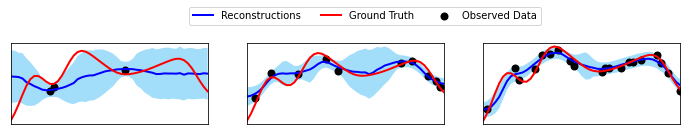

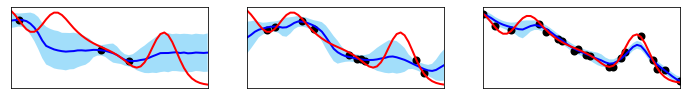

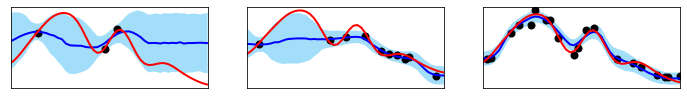

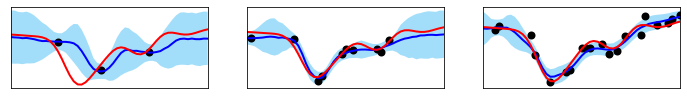

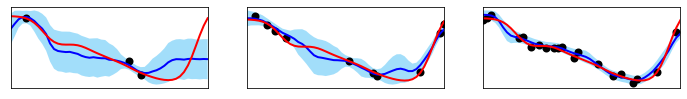

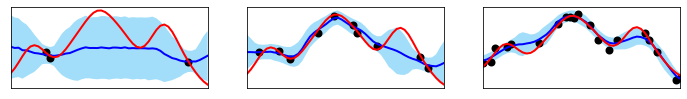

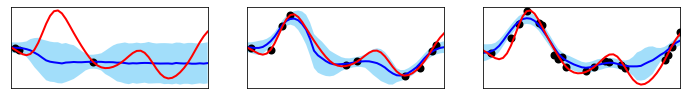

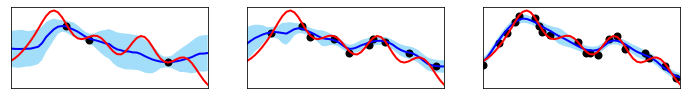

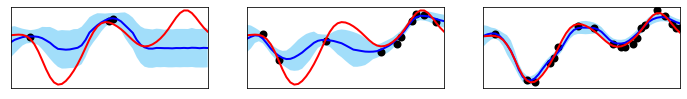

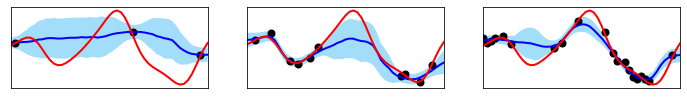

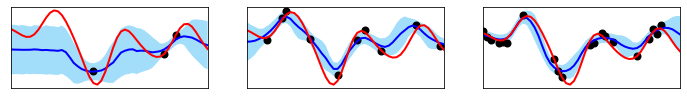

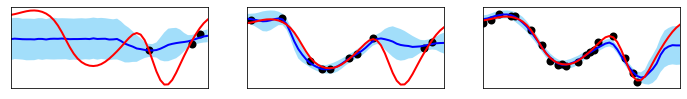

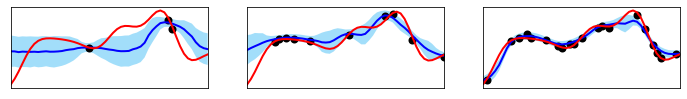

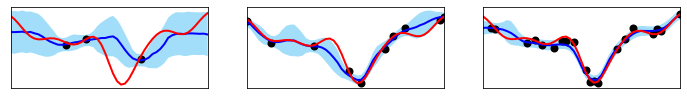

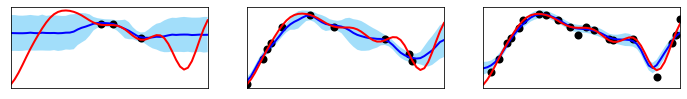

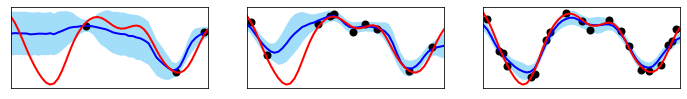

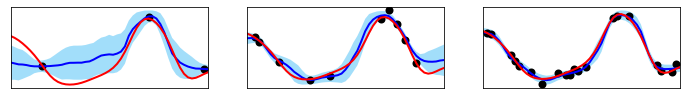

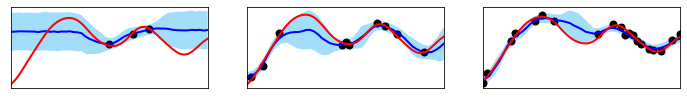

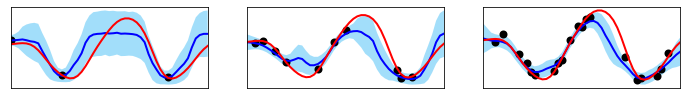

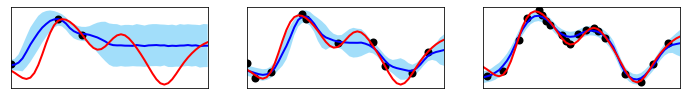

In [ ]:
viz(test_loader, k_iwae=100)

In [47]:

k_iwae=100  
n_max=20
pred_mean, pred_std = [], []
masks = []
targets = []
tp =[]
np.random.seed(0)
with torch.no_grad():
    for low in [3, 10, 20]:
        for batch in test_loader:
            batch_len = batch.shape[0]
            batch = batch.to(device)
            subsampled_mask = torch.zeros_like(batch[:, :, dim:2 * dim]).to(device)
            seqlen = batch.size(1)
            for i in range(batch_len):
                length = np.random.randint(low=low, high=low + 1)
                obs_points = np.sort(np.random.choice(np.arange(seqlen), size=length, replace=False))
                #subsampled_mask[i, obs_points, :] = 1
                subsampled_mask[i, obs_points, :] = 2
            recon_mask = batch[:, :, dim:2 * dim] - subsampled_mask
            context_y = torch.cat((batch[:, :, :dim] * subsampled_mask, subsampled_mask), -1)
            px, _ = net.get_reconstruction(batch[:, :, -1], context_y, batch[:, :, -1], num_samples=k_iwae)
            pred_mean.append(px.mean.cpu().numpy())
            pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
            targets.append((batch[:, :, :dim]).cpu().numpy())
            masks.append(subsampled_mask.cpu().numpy())
            tp.append(batch[:, :, -1].cpu().numpy())
            if len(tp) % (n_max // 5) == 0:
                    break
    
pred_mean = np.concatenate(pred_mean, axis=1)
pred_std = np.concatenate(pred_std, axis=1)
targets = np.concatenate(targets, axis=0)
masks = np.concatenate(masks, axis=0)
tp = np.concatenate(tp, axis=0)
inputs = np.ma.masked_where(masks < 1., targets)
print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
#quantile2 = np.quantile(preds, 0.841, axis=0)
#quantile1 = np.quantile(preds, 0.159, axis=0)

quantile2 = np.quantile(preds, 0.95, axis=0)
quantile1 = np.quantile(preds, 0.05, axis=0)

(100, 60, 51, 1) (100, 60, 51, 1) (60, 51, 1) (60, 51, 1) (60, 51)


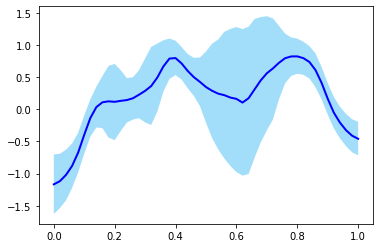

In [50]:
w = 2.0
plt.fill_between(tp[n_max * 1], quantile1[n_max * 1, :, 0], quantile2[n_max * 1, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
plt.plot(tp[n_max * 1], median[n_max * 1, :, 0], c='b', lw=w, label='Reconstructions')

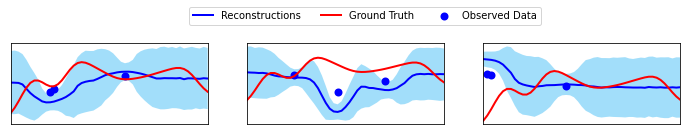

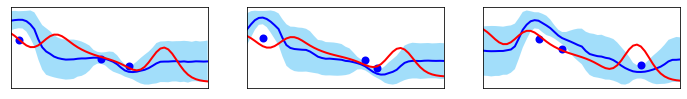

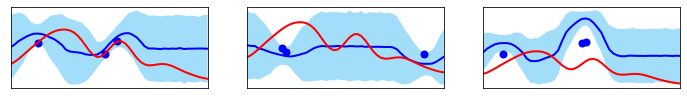

In [54]:
w = 2.0
n_max = 3
for index in range(n_max):
    plt.figure(figsize=(12, 1.5))
    for j in range(3):
        plt.subplot(1, 3, j + 1)
        plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
        plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
        plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
        plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='b', lw=w, label='Observed Data')
        plt.xlim([0, 1])
        plt.grid(":")
        plt.xticks([])
        plt.yticks([])
        if j == 1 and index == 0:
            plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
        
    plt.show()